In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = yf.download("YPF",progress=False)
df

Open    High     Low   Close  Adj Close    Volume
Date                                                           
1993-06-29  21.250  22.125  21.125  21.875   5.531449  34346800
1993-06-30  22.000  23.000  21.625  21.750   5.499842   9060600
1993-07-01  21.375  21.625  21.000  21.250   5.373409   4273100
1993-07-02  21.125  21.250  20.750  21.125   5.341802   2504500
1993-07-06  20.875  21.000  20.625  20.750   5.246974   2030400
...            ...     ...     ...     ...        ...       ...
2020-07-20   6.420   6.420   6.210   6.410   6.410000   1466600
2020-07-21   6.500   6.650   6.410   6.490   6.490000   1140100
2020-07-22   6.490   6.740   6.380   6.640   6.640000    995600
2020-07-23   6.700   7.030   6.570   6.810   6.810000   1636000
2020-07-24   6.650   6.750   6.490   6.660   6.660000   1498800

[6818 rows x 6 columns]

In [3]:
#Cambio indice de fecha a columna
df.reset_index(inplace=True,drop=False)

#Renombro las columnas
df.rename(columns={'Adj Close':'Adj_Close'}, inplace=True)

In [4]:
import talib
def get_all_indicators(dataframe):
    candles_indicators = dataframe.copy()    
    candles_indicators["RSI"] = talib.RSI(candles_indicators["Close"], timeperiod=14)
    candles_indicators["EMA12"] = talib.EMA(candles_indicators["Close"], timeperiod=12)
    candles_indicators["EMA26"] = talib.EMA(candles_indicators["Close"], timeperiod=26) 

    upper_band, middle_band, lower_band = talib.BBANDS(candles_indicators["Close"], timeperiod=20, 
                                                nbdevup=2, nbdevdn=2, matype=0)

    candles_indicators["Upper_BBand"] = upper_band
    candles_indicators["Middle_BBand"] = middle_band
    candles_indicators["Lower_BBand"] = lower_band


    macd, macd_signal, macd_hist = talib.MACD(candles_indicators["Close"], fastperiod=12, slowperiod=26, 
                                        signalperiod=9)

    #candles_indicators["MACD"] = macd 
    #candles_indicators["MACD_Signal"] = macd_signal 
    #candles_indicators["MACD_Hist"] = macd_hist

    k, d = talib.STOCH(candles_indicators["High"], candles_indicators["Low"], 
                candles_indicators["Close"], fastk_period=5, slowk_period=3, 
                slowk_matype=0, slowd_period=3, slowd_matype=0)

    candles_indicators["K"] = k
    candles_indicators["D"] = d
        
    return candles_indicators

In [5]:
df = get_all_indicators(df)
df.head()

Date    Open    High     Low   Close  Adj_Close    Volume  RSI  EMA12  \
0 1993-06-29  21.250  22.125  21.125  21.875   5.531449  34346800  NaN    NaN   
1 1993-06-30  22.000  23.000  21.625  21.750   5.499842   9060600  NaN    NaN   
2 1993-07-01  21.375  21.625  21.000  21.250   5.373409   4273100  NaN    NaN   
3 1993-07-02  21.125  21.250  20.750  21.125   5.341802   2504500  NaN    NaN   
4 1993-07-06  20.875  21.000  20.625  20.750   5.246974   2030400  NaN    NaN   

   EMA26  Upper_BBand  Middle_BBand  Lower_BBand   K   D  
0    NaN          NaN           NaN          NaN NaN NaN  
1    NaN          NaN           NaN          NaN NaN NaN  
2    NaN          NaN           NaN          NaN NaN NaN  
3    NaN          NaN           NaN          NaN NaN NaN  
4    NaN          NaN           NaN          NaN NaN NaN

## Feature engineering

In [6]:
#Convertimos la variable objeto en datetime
df["Date"] = pd.to_datetime(df["Date"])
#Creamos nuevas variables
df["day"] = df["Date"].dt.day
df["day_of_week"] = df["Date"].dt.weekday
df["week"] = df["Date"].dt.week
df["month"] = df["Date"].dt.month
df["quarter"] = df["Date"].dt.quarter
df["year"] = df["Date"].dt.year
#df.drop(columns=['Date'], inplace=True)
df.head()

Date    Open    High     Low   Close  Adj_Close    Volume  RSI  EMA12  \
0 1993-06-29  21.250  22.125  21.125  21.875   5.531449  34346800  NaN    NaN   
1 1993-06-30  22.000  23.000  21.625  21.750   5.499842   9060600  NaN    NaN   
2 1993-07-01  21.375  21.625  21.000  21.250   5.373409   4273100  NaN    NaN   
3 1993-07-02  21.125  21.250  20.750  21.125   5.341802   2504500  NaN    NaN   
4 1993-07-06  20.875  21.000  20.625  20.750   5.246974   2030400  NaN    NaN   

   EMA26  ...  Middle_BBand  Lower_BBand   K   D  day  day_of_week  week  \
0    NaN  ...           NaN          NaN NaN NaN   29            1    26   
1    NaN  ...           NaN          NaN NaN NaN   30            2    26   
2    NaN  ...           NaN          NaN NaN NaN    1            3    26   
3    NaN  ...           NaN          NaN NaN NaN    2            4    26   
4    NaN  ...           NaN          NaN NaN NaN    6            1    27   

   month  quarter  year  
0      6        2  1993  
1      6        2  1993  
2      7        3  1993  
3      7        3  1993  
4      7        3  1993  

[5 rows x 21 columns]

In [7]:
df['discrete_rsi'] = 0
df.loc[df.RSI >= 70, 'discrete_rsi'] = 1
df.loc[df.RSI <= 30, 'discrete_rsi'] = -1

In [8]:
df['discrete_ema12_ema26'] = -1
df.loc[df.EMA12 > df.EMA26, 'discrete_ema12_ema26'] = 1

In [9]:
df['discrete_ema_12'] = 0
df.loc[df.Close > df.EMA12, 'discrete_ema_12'] = 1
df.loc[df.Close < df.EMA12, 'discrete_ema_12'] = -1

In [10]:
df['discrete_bollinger_bands'] = 0
df.loc[df.Close > df.Upper_BBand, 'discrete_bollinger_bands'] = 1
df.loc[df.Close < df.Lower_BBand, 'discrete_bollinger_bands'] = -1

In [11]:
df.loc[df.K > 80, 'discrete_stochastic'] = 1
df.loc[df.K < 20, 'discrete_stochastic'] = -1

In [12]:
df['discrete_kd'] = 0
df.loc[df.K > df.D, 'discrete_kd'] = 1
df.loc[df.K < df.D, 'discrete_kd'] = -1

In [13]:
df.dropna(inplace=True)
df

Date    Open    High     Low   Close  Adj_Close   Volume  \
26   1993-08-05  20.375  20.375  20.000  20.000   5.057325   825000   
27   1993-08-06  20.000  20.125  19.625  19.875   5.025720  1318700   
31   1993-08-12  20.625  21.000  20.500  20.875   5.278584  1160100   
32   1993-08-13  21.000  21.625  21.000  21.625   5.468234  1763600   
33   1993-08-16  21.625  22.125  21.500  22.000   5.563060  1182400   
...         ...     ...     ...     ...     ...        ...      ...   
6799 2020-06-29   5.720   5.890   5.720   5.850   5.850000  1424000   
6800 2020-06-30   5.730   5.810   5.580   5.750   5.750000  2280700   
6801 2020-07-01   5.740   5.870   5.690   5.810   5.810000  1049700   
6807 2020-07-10   6.110   6.320   6.110   6.300   6.300000   725600   
6811 2020-07-16   6.410   6.590   6.350   6.520   6.520000  1186300   

            RSI      EMA12      EMA26  ...  week  month  quarter  year  \
26    36.787525  20.213024  20.329416  ...    31      8        3  1993   
27    35.341210  20.161020  20.295756  ...    31      8        3  1993   
31    53.029589  20.363126  20.363586  ...    32      8        3  1993   
32    62.370033  20.557261  20.457024  ...    32      8        3  1993   
33    66.009634  20.779220  20.571319  ...    33      8        3  1993   
...         ...        ...        ...  ...   ...    ...      ...   ...   
6799  57.478860   5.665030   5.460948  ...    27      6        2  2020   
6800  55.430927   5.678103   5.482359  ...    27      6        2  2020   
6801  56.433907   5.698394   5.506629  ...    27      7        3  2020   
6807  62.429247   5.989666   5.741208  ...    28      7        3  2020   
6811  65.068616   6.196083   5.915996  ...    29      7        3  2020   

      discrete_rsi  discrete_ema12_ema26  discrete_ema_12  \
26               0                    -1               -1   
27               0                    -1               -1   
31               0                    -1                1   
32               0                     1                1   
33               0                     1                1   
...            ...                   ...              ...   
6799             0                     1                1   
6800             0                     1                1   
6801             0                     1                1   
6807             0                     1                1   
6811             0                     1                1   

      discrete_bollinger_bands  discrete_stochastic  discrete_kd  
26                           0                 -1.0           -1  
27                           0                 -1.0           -1  
31                           0                  1.0            1  
32                           1                  1.0            1  
33                           1                  1.0            1  
...                        ...                  ...          ...  
6799                         0                  1.0            1  
6800                         0                  1.0            1  
6801                         0                  1.0           -1  
6807                         0                  1.0            1  
6811                         0                  1.0            1  

[2249 rows x 27 columns]

In [14]:
df.drop(columns=['RSI','EMA12', 'EMA26', 'Upper_BBand','Lower_BBand', 'Middle_BBand', 'K','D'], inplace=True)
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'day',
       'day_of_week', 'week', 'month', 'quarter', 'year', 'discrete_rsi',
       'discrete_ema12_ema26', 'discrete_ema_12', 'discrete_bollinger_bands',
       'discrete_stochastic', 'discrete_kd'],
      dtype='object')

In [15]:
train, no_train = train_test_split(df, train_size=0.70, shuffle=False, random_state=42)
test, validation = train_test_split(no_train, train_size=0.5, shuffle=False, random_state=42)
print(len(train))
print(len(test))
print(len(validation))

1574
337
338


In [16]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler(feature_range = (0, 1))
test_scaler = MinMaxScaler(feature_range = (0, 1))
validation_scaler = MinMaxScaler(feature_range = (0, 1))

In [17]:
#x_train = train.drop(columns=['Open','High','Low','Close','Adj_Close','Volume'])
#y_train = train.Adj_Close

#x_test = test.drop(columns=['Open','High','Low','Close','Adj_Close','Volume'])
#y_test = test.Adj_Close

In [18]:
#print('x_train', x_train.shape)
#print('y_train', y_train.shape)
#print('x_test', x_test.shape)
#print('y_test', y_test.shape)

## Conjunto de datos de train

In [19]:
training_set = np.array(train['Adj_Close']).reshape(-1,1)
training_set_scaled = train_scaler.fit_transform(training_set)

In [41]:
window_size = 32

X_train = []
y_train = []
for i in range(window_size, len(train)):
    X_train.append(training_set_scaled[i-window_size:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Conjunto de datos de test

In [21]:
test_set = np.array(test['Adj_Close']).reshape(-1,1)
test_set_scaled = test_scaler.fit_transform(test_set)

In [22]:
X_test = []
y_test = []
for i in range(window_size, len(test)):
    X_test.append(test_set_scaled[i-window_size:i, 0])
    y_test.append(test_set_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Modelo LSTM

In [25]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [52]:

regressor = Sequential()

regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 64))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32, 64)            16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32, 64)            33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 64)            33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)               

In [53]:
history = regressor.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs = 50, 
                        batch_size = 32)

Epoch 1/50
49/49 [==============================] - 10s 199ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 2/50
49/49 [==============================] - 7s 144ms/step - loss: 0.0052 - val_loss: 0.0168
Epoch 3/50
49/49 [==============================] - 7s 143ms/step - loss: 0.0053 - val_loss: 0.0163
Epoch 4/50
49/49 [==============================] - 7s 143ms/step - loss: 0.0044 - val_loss: 0.0142
Epoch 5/50
49/49 [==============================] - 7s 143ms/step - loss: 0.0042 - val_loss: 0.0135
Epoch 6/50
49/49 [==============================] - 7s 142ms/step - loss: 0.0036 - val_loss: 0.0133
Epoch 7/50
49/49 [==============================] - 7s 143ms/step - loss: 0.0040 - val_loss: 0.0120
Epoch 8/50
49/49 [==============================] - 7s 149ms/step - loss: 0.0035 - val_loss: 0.0111
Epoch 9/50
49/49 [==============================] - 8s 161ms/step - loss: 0.0038 - val_loss: 0.0107
Epoch 10/50
49/49 [==============================] - 7s 146ms/step - loss: 0.0035 - val_loss: 0.009

In [26]:
regressor = load_model('./models/lstm1.h5')

In [28]:
from matplotlib import pyplot as plt

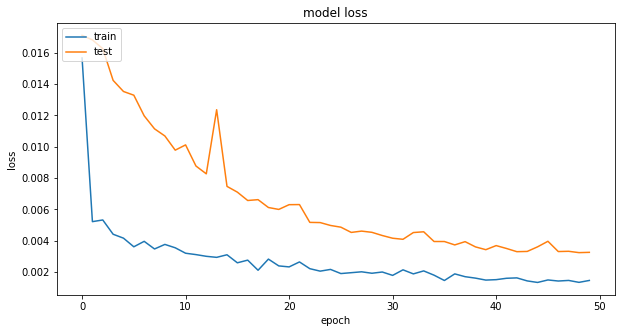

In [57]:
#summarize history for loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

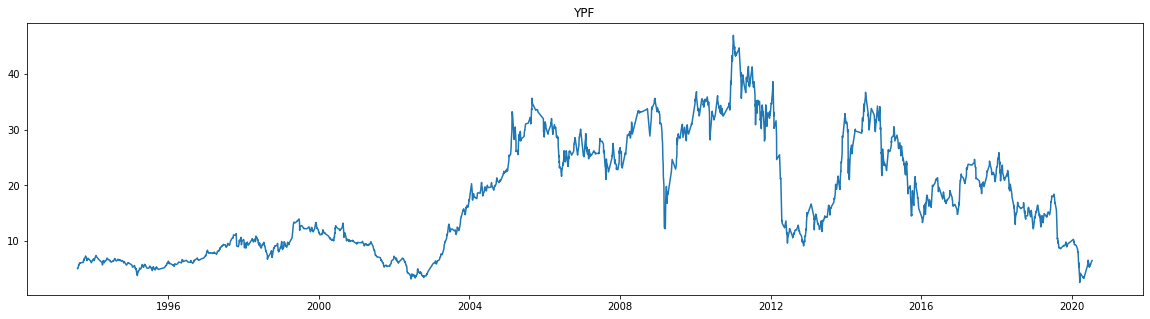

In [60]:
plt.figure(figsize=(20, 5))
plt.plot(df.Date, df.Adj_Close)
plt.title('YPF')
plt.show()

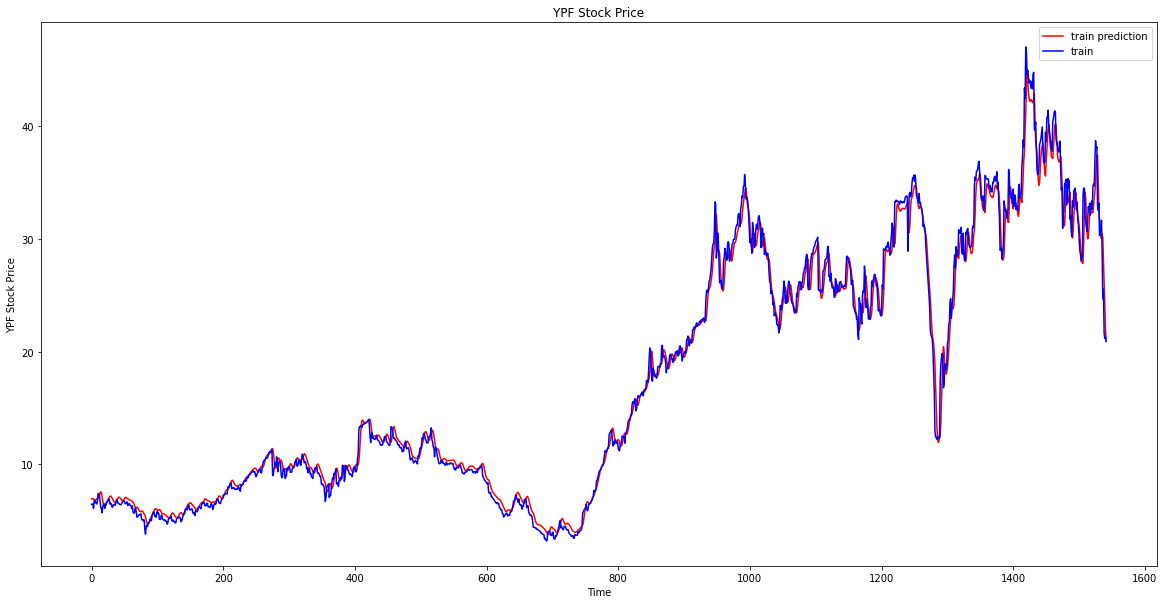

In [98]:
train_prediction = train_scaler.inverse_transform(regressor.predict(X_train))

plt.figure(figsize=(20, 10))
plt.plot(train_prediction[:], color = 'red', label = 'train prediction')
plt.plot(training_set[window_size:], color = 'blue', label = 'train')
plt.title('YPF Stock Price')
plt.xlabel('Time')
plt.ylabel('YPF Stock Price')
plt.legend()
plt.show()

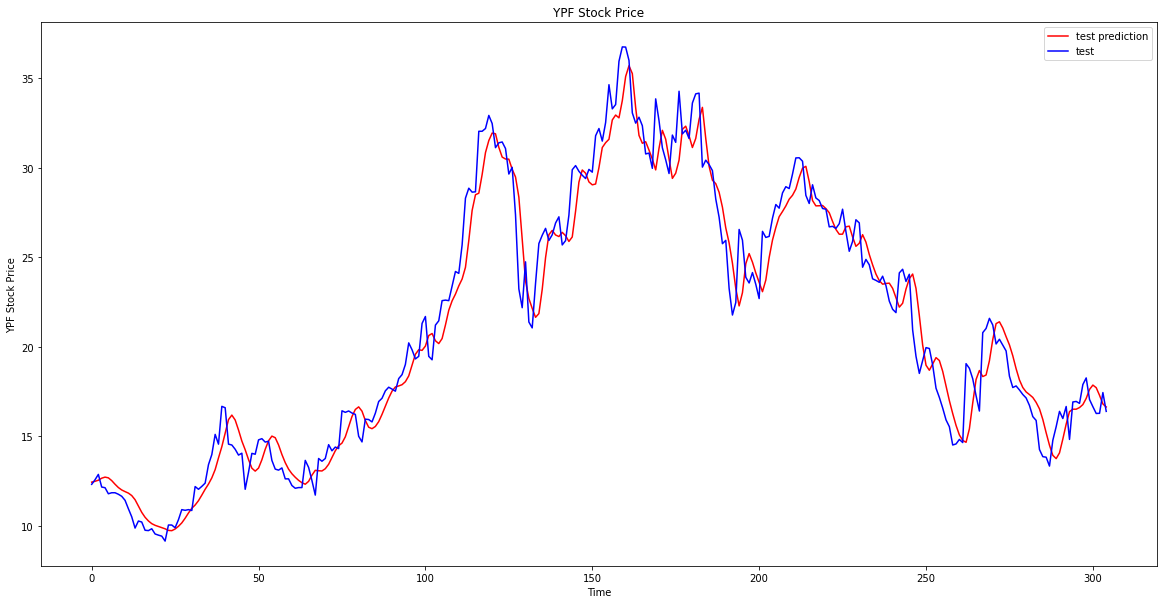

In [99]:
test_prediction = test_scaler.inverse_transform(regressor.predict(X_test))

plt.figure(figsize=(20, 10))
plt.plot(test_prediction, color = 'red', label = 'test prediction')
plt.plot(test_set[window_size:], color = 'blue', label = 'test')
plt.title('YPF Stock Price')
plt.xlabel('Time')
plt.ylabel('YPF Stock Price')
plt.legend()
plt.show()

In [45]:
val_set = np.array(validation['Adj_Close']).reshape(-1,1)
val_set_scaled = validation_scaler.fit_transform(val_set)

In [46]:
X_val = []
y_val = []
for i in range(window_size, len(validation)):
    X_val.append(val_set_scaled[i-window_size:i, 0])
    y_val.append(val_set_scaled[i, 0])
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

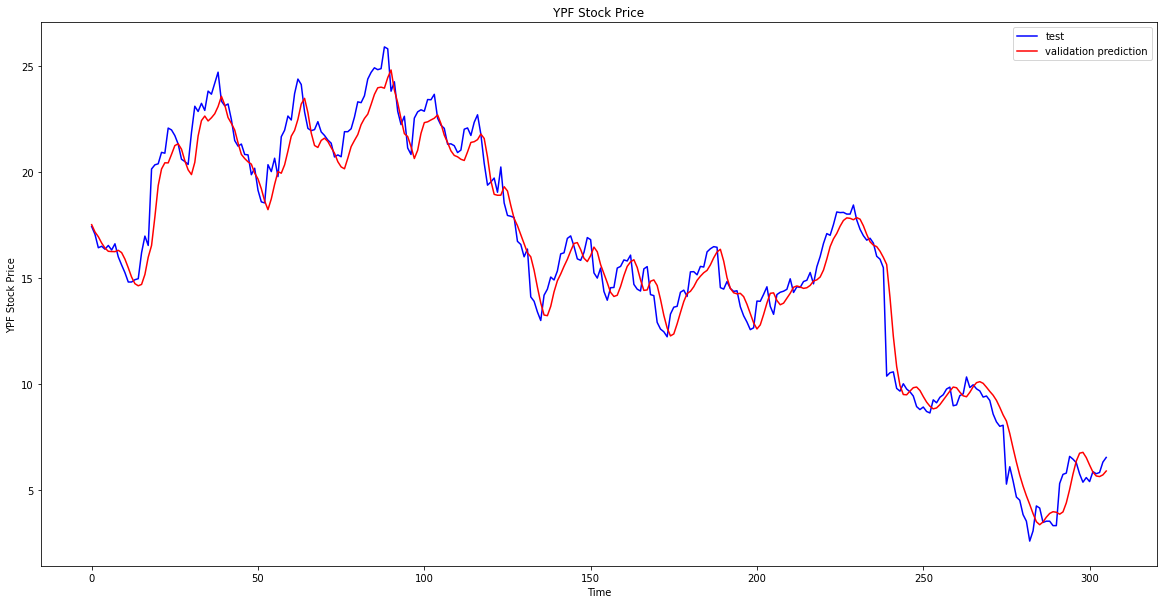

In [100]:
val_predictions = validation_scaler.inverse_transform(regressor.predict(X_val))

plt.figure(figsize=(20, 10))
plt.plot(val_set[window_size:], color = 'blue', label = 'test')
plt.plot(val_predictions, color = 'red', label = 'validation prediction')
plt.title('YPF Stock Price')
plt.xlabel('Time')
plt.ylabel('YPF Stock Price')
plt.legend()
plt.show()

In [ ]:
df['difference'] = -df.Adj_Close.diff(-1)

df.loc[df.difference > 0, 'target'] = 1
df.loc[df.difference < 0, 'target'] = 0

df.drop(columns='difference', inplace=True)
df.dropna(inplace=True)

df